# Classification using pytorch

In this exercise we will use pytorch to perform a 2-classes classification exercice. For this we will first implement the logistic regression method and observe that it performs rather poorly. Then we will implement a simple neural network and show that the classification can be greatly improved.

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer

print('Run on cpu')
dtype = torch.FloatTensor
device = torch.device("cpu")

# fix random generators seed for reproducibility
torch.manual_seed(42)
np.random.seed(seed=42)


Run on cpu


# 1. Generation of the samples

Just run the few cells below to generate the two classes: a 'background' sample and a 'signal' sample.

In [2]:
Nsample = 10000 # Number of events in each sample
features=["x0","x1","x2","x3","x4","x5"] # feature names

In [3]:
# Generation of background sample
# The first 5 features are samples from a multi-dimensional gaussian function. 
# The 6-th feature is constructed from the 5 others.

covMatrix = np.array([[ 0.81652219,  0.12798401,  0.25894314, -0.65065863,  1.24887103],
       [ 0.12798401,  0.90369306, -0.0297507 , -0.27944877,  2.31268408],
       [ 0.25894314, -0.0297507 ,  1.27407394,  0.5200441 , -0.0738098 ],
       [-0.65065863, -0.27944877,  0.5200441 , 19.43674212, -5.04547895],
       [ 1.24887103,  2.31268408, -0.0738098 , -5.04547895, 23.93837133]])

Nvar = 5
mean = np.random.randn(Nvar)
cov = covMatrix
x = np.random.multivariate_normal(mean, cov, Nsample)

# 6-th feature
m = np.sqrt(np.sum(x**2,axis=1))
m = m.reshape(Nsample,1)

# Put sample in a panda dataframe
data = np.concatenate((x,m),axis=1)
background = pd.DataFrame(data,columns=features)

In [4]:
# Now we generate the signal sample
# We use a custom function from scikit-learn that generates 'blobs' of data

from sklearn.datasets import make_blobs
centers = [[0,2,-2,0,0,6]] # center of the blobs
X, y = make_blobs(n_samples=Nsample, cluster_std=2.5, centers=centers, n_features=6, random_state=40)

signal = pd.DataFrame(X,columns=features)

In [5]:
# Here we add a column of label to each sample: 0=background, 1=signal

z=pd.DataFrame(np.zeros(len(background)))
background["label"]=pd.DataFrame(z)

o=pd.DataFrame(np.ones(len(signal)))
signal["label"]=pd.DataFrame(o)

## 2. Data exploration

a) Make histograms of each features for both classes

b) Look at how the features are correlated, for both classes

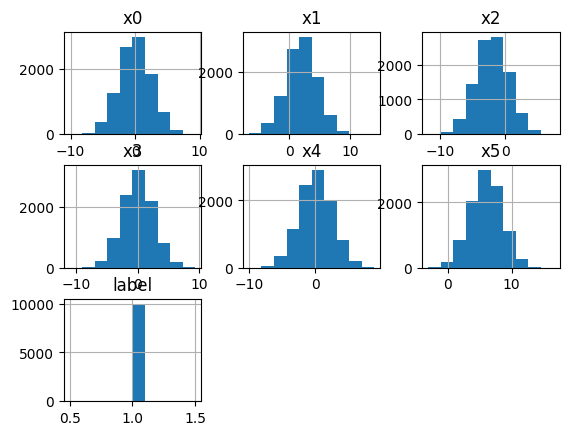

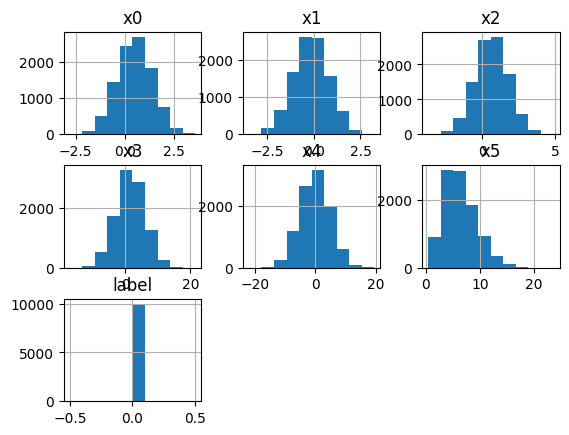

In [20]:
signal.hist();
background.hist();

In [41]:
print('signal.corr \n', signal[features].corr(), '\n\n');
print('background.corr() \n', background[features].corr());

signal.corr 
           x0        x1        x2        x3        x4        x5
x0  1.000000  0.017919 -0.012497  0.013949  0.018498 -0.008870
x1  0.017919  1.000000 -0.004612 -0.005792  0.008326  0.002991
x2 -0.012497 -0.004612  1.000000 -0.003653  0.006859  0.005397
x3  0.013949 -0.005792 -0.003653  1.000000 -0.019502  0.000699
x4  0.018498  0.008326  0.006859 -0.019502  1.000000  0.008666
x5 -0.008870  0.002991  0.005397  0.000699  0.008666  1.000000 


background.corr() 
           x0        x1        x2        x3        x4        x5
x0  1.000000  0.151498  0.265934 -0.163749  0.292086 -0.015363
x1  0.151498  1.000000 -0.025908 -0.073625  0.493347 -0.027986
x2  0.265934 -0.025908  1.000000  0.106835 -0.003476  0.068931
x3 -0.163749 -0.073625  0.106835  1.000000 -0.252776  0.291316
x4  0.292086  0.493347 -0.003476 -0.252776  1.000000 -0.078687
x5 -0.015363 -0.027986  0.068931  0.291316 -0.078687  1.000000


# 3. Prepare the data for pytorch

First we separate each sample in three data sets: train, validation and test, with fractions 40%, 20%, 40% respectively.

Then we feed these datasets to the DataLoader utility that is quite helpful to split the data in batches in view of the training.

Just run the two cells below.

In [6]:
# Separate train, validation and test data (40,20,40)

x_background_train,x_background_test = train_test_split(background.values,test_size=0.4) 
x_background_train_train,x_background_train_valid = train_test_split(x_background_train,test_size=0.33) 

x_signal_train,x_signal_test = train_test_split(signal.values,test_size=0.4) 
x_signal_train_train,x_signal_train_valid = train_test_split(x_signal_train,test_size=0.33) 

In [7]:
# Data loader

batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_train_train,x_signal_train_train)),
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_train_valid,x_signal_train_valid)),
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_test,x_signal_test)),
                                          batch_size=batch_size,
                                          shuffle=False)


# 4. Build models

1) Construct a first model class that implements the logistic regression method.
- input layer (6 nodes)
- output layer (1 node)
- Sigmoid activation function

2) Construct another model class that implements a simple MLP with the following structure:
- input layer (6 nodes)
- hidden layer with 200 nodes
- ReLU activation function
- output layer (1 node)
- Sigmoid activation function

As an example you can look this page: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

In [8]:
input_dim, hidden_dim, output_dim = 6, 200, 1

In [9]:
# Logistic regression
class LogRegression(nn.Module):
    """FILL HERE"""

In [10]:
# MLP with one hidden layer
class MLP(nn.Module):
    "FILL HERE"

# 5. Train model

After choosing some setting for the training run the training on your model (either the Log regr ot the MLP)

a) Complete the cell below.

b) Modify the code to store values of train and validation loss values at each epoch

c) Run the training and make a plot of the loss values for the training and validation steps

In [11]:
# Training settings

# Choose and initialise your model
model = """ FILL HERE """

# Choose number of epochs
num_epochs = 50

# Setup the Binary Cross Entropy loss function
criterion = nn.BCELoss() 

# Optimisation model, here we choose Adam which is stochastic gradient descent with improvements
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay = 1e-5) 

AttributeError: 'str' object has no attribute 'parameters'

In [ ]:
for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        # ===================forward=====================
        output = model(""" FILL HERE """)[:,0]
        target = data[""" FILL HERE """]
        loss = criterion(output, target)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        """ FILL HERE
        The main difference with the training
        is that there is no optimization of the weights of the mode """

"""FILL HERE
Modify the code above to store values of train and validation 
loss values at each epoch. use them to plot the model performance 
once the training is done."""


# 6. Test phase and results

For both models (logistic regression then MLP)

a) Apply the trained model to test samples

b) Show the histograms of the model output for both background and signal samples. 

c) Display the confusion matrix (threshold = 0.5)

d) Show the ROC curve

e) Conclusions: Is the separation satisfactory for the case of the logistic regression ? What about the performance for the MLP ?
